## The VGG Block
One VGG block consists of:
- **a sequence of convolutional layers**;
- **a maximum pooling layer for spatial downsampling.**

In the original VGG paper, a VGG block is consisted of:
- $3 \times 3$ kernels with padding of 1(1 on both sides);
- $ 2 \times 2$ maximum pooling with stride of 2.
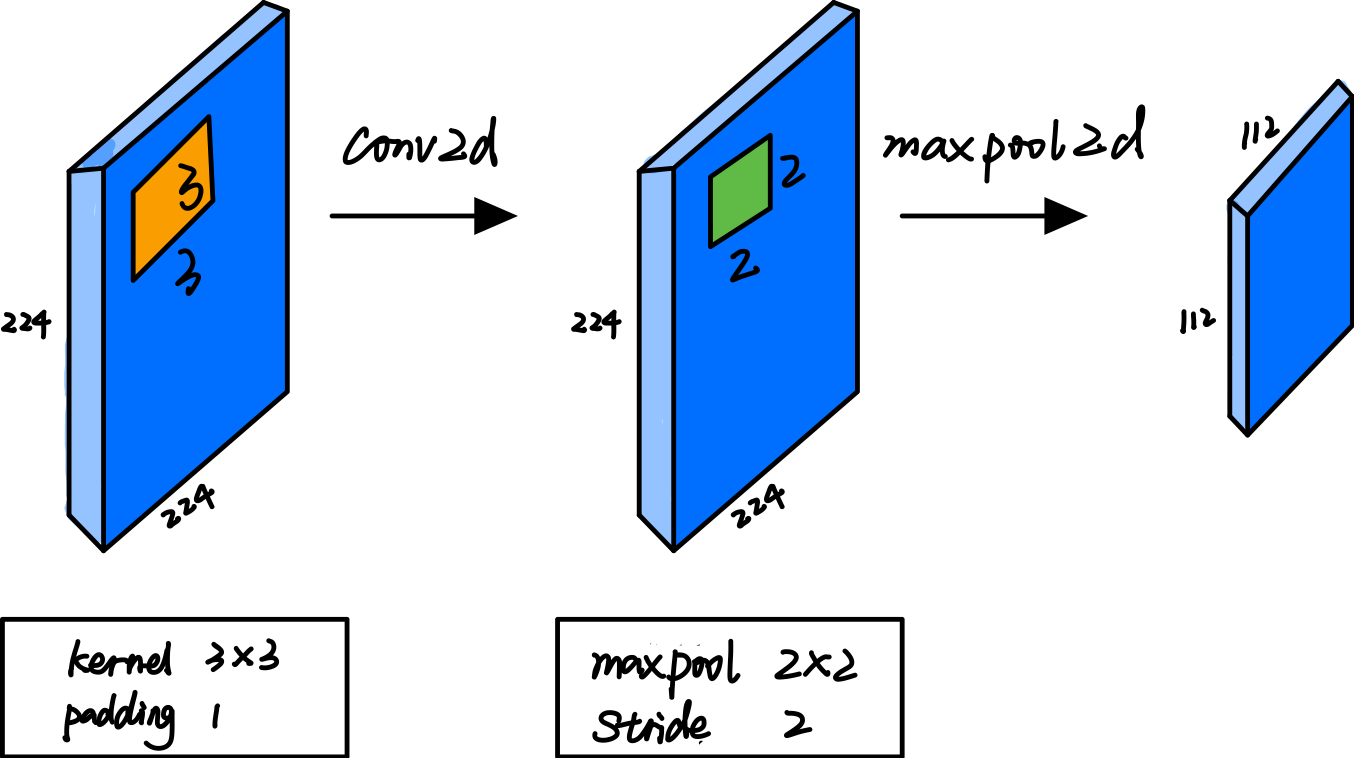

In [13]:
import torch
from torch import nn
import torchvision

In [14]:
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    
    for i in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
        
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    
    return nn.Sequential(*layers)

## The VGG network

The VGG network is like the AlexNet, consisting of a series of convolutional layers and poolings, and a series of fully-connected layers.
![](vgg.svg)

## Implementation of VGG-11
The VGG-11 network uses 8 convolutional layers and 3 fully connected layers. We are using the FashionMNIST dataset for training and testing. The `input_channel` parameter for the firsr layer is 1.

In [15]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

In [16]:
def vgg(conv_arch):
    conv_blks = []
    
    in_channels = 1
    
    # add vgg blocks
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels
    
    # add fully connected layers
    return nn.Sequential(*conv_blks, 
                         nn.Flatten(),
                         # erveytime the image go through 1 vgg block, the 
                         # image size will reduce by half, so after 5 vgg blocks, 
                         # the image size is now 224/32 = 7
                         nn.Linear(out_channels*7*7, 4096), nn.ReLU(), nn.Dropout(0.5),
                         nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5), 
                         nn.Linear(4096, 10)
                        )

In [17]:
vgg_11 = vgg(conv_arch)

In [18]:
# A simple test for vgg-11
X = torch.randn(size=(1,1,224,224))

for submodule in vgg_11:
    X = submodule(X)
    print(submodule.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


## Dataset

In [19]:
import sys
sys.path.append("../dlutils")

In [20]:
from dataset import load_fashion_mnist_dataset
batch_size = 128
train_loader, test_loader = load_fashion_mnist_dataset(batch_size=batch_size, resize=224)

## Loss

In [21]:
loss = torch.nn.CrossEntropyLoss()

## Optimizer

In [22]:
lr = 0.05
trainer = torch.optim.SGD(vgg_11.parameters(), lr = lr)

## Training

In [23]:
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from train import train_3ch
vgg_11.to(device)
loss.to(device)
train_3ch(vgg_11, loss, num_epochs, train_loader, trainer, test_loader, device)

epoch 0, training loss 0.017998, training accuracy 0.100000, testing loss 0.018190, testing accuracy 0.100000
epoch 1, training loss 0.017979, training accuracy 0.100000, testing loss 0.018171, testing accuracy 0.100000
epoch 2, training loss 0.004719, training accuracy 0.763167, testing loss 0.004899, testing accuracy 0.759000
epoch 3, training loss 0.004185, training accuracy 0.783533, testing loss 0.004555, testing accuracy 0.768600
epoch 4, training loss 0.002937, training accuracy 0.856700, testing loss 0.003247, testing accuracy 0.845100
epoch 5, training loss 0.001993, training accuracy 0.902283, testing loss 0.002415, testing accuracy 0.886100
epoch 6, training loss 0.001951, training accuracy 0.902083, testing loss 0.002505, testing accuracy 0.884100
epoch 7, training loss 0.001311, training accuracy 0.939050, testing loss 0.001965, testing accuracy 0.909300
epoch 8, training loss 0.001129, training accuracy 0.946800, testing loss 0.002014, testing accuracy 0.912300
epoch 9, t